In [1]:
%cd ..

/home/dev/24/es-bench


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
from datetime import datetime

import yaml
import pandas as pd
import numpy as np
from scipy import stats
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt

from cd import draw_cd_diagram

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logs_root = Path("log")

In [4]:
METRIC_FOR_DS = {
    "mimic3": "MulticlassAUROC",
    "physionet2012": "MulticlassAUROC",
    "age": "MulticlassAccuracy",
    "x5": "MulticlassAccuracy",
    "pendulum": "R2Score",
    "taobao": "MulticlassAUROC",
    "mbd": "MultiLabelMeanAUROC",
}
METRIC_PRETTY = {
    "MIMIC-III": "ROC AUC",
    "PhysioNet2012": "ROC AUC",
    "Age": "Accuracy",
    "Retail": "Accuracy",
    "Pendulum": "R2",
    "Taobao": "ROC AUC",
    "MBD": "Mean ROC AUC",
}
METHODS = [
    "gru",
    "coles",
    "mlem",
    "mlp",
    "mamba",
    "transformer",
    "mtand",
    "primenet",
]
METHODS_PRETTY = {
    "mtand": "mTAND",
    "gru": "GRU",
    "mlp": "MLP",
    "mamba": "Mamba",
    "coles": "CoLES",
    "primenet": "PrimeNet",
    "mlem": "MLEM",
    "transformer": "Transformer",
}
DATASETS = [
    "x5",
    "mbd",
    "age",
    "physionet2012",
    "mimic3",
    "pendulum",
    "taobao",
]
DATASETS_PRETTY = {
    "x5": "Retail",
    "age": "Age",
    "physionet2012": "PhysioNet2012",
    "pendulum": "Pendulum",
    "mimic3": "MIMIC-III",
    "mbd": "MBD",
    "taobao": "Taobao",
}


def print_latex(df):
    df = df.copy()
    df.columns = pd.MultiIndex.from_tuples(
        [
            (f"\\textbf{{{col}}}", f"\\footnotesize{{{METRIC_PRETTY[col]}}}")
            for col in df.columns
        ],
        names=["Dataset", "\\footnotesize{Metric}"],
    )
    df.index.name = None
    print(df.to_latex(bold_rows=True, column_format="r" + "c" * len(df.columns)))

# Pick config details

In [5]:
opts = []

for d in DATASETS:
    for m in METHODS:
        path = logs_root / d / m / "correlation" / "seed_0" / "config.yaml"
        with open(path) as f:
            config = yaml.load(f, yaml.SafeLoader)
        try:
            opt = config["model"]["preprocess"]["params"]["time_process"]
        except KeyError:
            opt = None
            
        opts.append(dict(
            dataset=d,
            method=m,
            option=opt
        ))

df_options = (
    pd.DataFrame(opts)
    .assign(method=lambda df: df.method.replace(METHODS_PRETTY))
    .assign(dataset=lambda df: df.dataset.replace(DATASETS_PRETTY))
)
df_options.pivot(index="method", columns="dataset", values="option")

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
method,,,,,,,
CoLES,cat,cat,diff,cat,cat,none,diff
GRU,cat,cat,cat,cat,none,diff,diff
MLP,cat,cat,cat,cat,diff,diff,diff
Mamba,diff,cat,cat,cat,cat,diff,diff
PrimeNet,diff,cat,diff,cat,diff,none,diff
Transformer,diff,cat,cat,cat,cat,cat,cat
mTAND,diff,cat,diff,cat,cat,none,diff


# Collect metrics from experiments

## Main

In [6]:
ms = []
for d in DATASETS:
    for m in METHODS:
        path = logs_root / d / m / "correlation" / "results.csv"
        try:
            res = pd.read_csv(path, index_col=0)
        except FileNotFoundError:
            print(f"Skipping {path}")
        else:
            ms.append(pd.DataFrame(dict(
                dataset=d,
                method=m,
                exp="main",
                seed=res.columns[:-2],
                metric=res.loc["test_" + METRIC_FOR_DS[d]].values[:-2],
            )))

df_eval = (
    pd.concat(ms)
    .assign(method=lambda df: df.method.replace(METHODS_PRETTY))
    .assign(dataset=lambda df: df.dataset.replace(DATASETS_PRETTY))
)
df_eval.pivot_table(index="method", columns="dataset", values="seed", aggfunc="count")

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
method,,,,,,,
CoLES,20,20,20,20,20,20,20
GRU,20,20,20,20,20,20,20
MLP,20,20,20,20,20,20,20
Mamba,20,20,20,20,20,20,20
PrimeNet,20,20,20,20,20,20,20
Transformer,20,20,20,20,20,20,20
mTAND,20,20,20,20,20,20,20


## Time ablation

In [20]:
df_time = (
    pd.read_csv(logs_root / "time.csv")
    .assign(exp="time")
    .query("dataset != 'amex'")
    .assign(method=lambda df: df.method.replace(METHODS_PRETTY))
    .assign(dataset=lambda df: df.dataset.replace(DATASETS_PRETTY))
)
df_time.pivot_table(index="method", columns="dataset", values="seed", aggfunc="count")

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,20,20,20,20,20
GRU,20,20,20,20,20
MLP,20,20,20,20,20
Mamba,20,20,20,20,20
PrimeNet,20,20,20,20,20
mTAND,20,20,20,20,20


In [13]:
df_perm_kl = (
    pd.read_csv(logs_root / "permutation_keep_last.csv")
    .assign(exp="perm_kl")
    .query("dataset != 'amex'")
    .assign(method=lambda df: df.method.replace(METHODS_PRETTY))
    .assign(dataset=lambda df: df.dataset.replace(DATASETS_PRETTY))
)
df_perm_kl.pivot_table(index="method", columns="dataset", values="seed", aggfunc="count")

,metric,dataset,method,seed,exp
0,0.603861,Age,Mamba,0,perm_kl
1,0.602211,Age,Mamba,1,perm_kl
2,0.590827,Age,Mamba,2,perm_kl
3,0.604191,Age,Mamba,3,perm_kl
4,0.603696,Age,Mamba,4,perm_kl
...,...,...,...,...,...
595,0.884485,MIMIC-III,CoLES,15,perm_kl
596,0.884754,MIMIC-III,CoLES,16,perm_kl
597,0.883535,MIMIC-III,CoLES,17,perm_kl
598,0.887248,MIMIC-III,CoLES,18,perm_kl


# Main metrics

In [7]:
main_res = df_eval.pivot_table(
    index="method",
    columns="dataset",
    values="metric",
    aggfunc=["mean", "std"],
)
main_res_latex = (
    main_res.loc[:, "mean"].map(lambda x: f"${x:.3f} \pm ")
    + main_res.loc[:, "std"].map(lambda x: f"{x:.3f}$")
)
main_res_latex

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
method,,,,,,,
CoLES,$0.634 \pm 0.005$,$0.826 \pm 0.001$,$0.902 \pm 0.001$,$0.916 \pm 0.004$,$0.840 \pm 0.004$,$0.553 \pm 0.002$,$0.713 \pm 0.002$
GRU,$0.626 \pm 0.004$,$0.827 \pm 0.001$,$0.901 \pm 0.002$,$0.896 \pm 0.010$,$0.846 \pm 0.004$,$0.543 \pm 0.002$,$0.713 \pm 0.004$
MLP,$0.581 \pm 0.007$,$0.809 \pm 0.001$,$0.881 \pm 0.001$,$0.165 \pm 0.005$,$0.835 \pm 0.004$,$0.526 \pm 0.002$,$0.659 \pm 0.035$
Mamba,$0.609 \pm 0.006$,$0.820 \pm 0.003$,$0.895 \pm 0.002$,$0.908 \pm 0.005$,$0.835 \pm 0.006$,$0.538 \pm 0.003$,$0.693 \pm 0.023$
PrimeNet,$0.583 \pm 0.011$,$0.780 \pm 0.006$,$0.887 \pm 0.004$,$0.842 \pm 0.017$,$0.839 \pm 0.004$,$0.521 \pm 0.003$,$0.681 \pm 0.010$
Transformer,$0.621 \pm 0.006$,$0.821 \pm 0.002$,$0.894 \pm 0.002$,$0.891 \pm 0.015$,$0.838 \pm 0.008$,$0.536 \pm 0.006$,$0.692 \pm 0.013$
mTAND,$0.582 \pm 0.009$,$0.798 \pm 0.002$,$0.888 \pm 0.003$,$0.941 \pm 0.009$,$0.841 \pm 0.005$,$0.519 \pm 0.003$,$0.672 \pm 0.010$


In [19]:
print_latex(main_res_latex)

\begin{tabular}{rcccccc}
\toprule
Dataset & \textbf{Age} & \textbf{MIMIC-III} & \textbf{Pendulum} & \textbf{PhysioNet2012} & \textbf{Retail} & \textbf{Taobao} \\
\footnotesize{Metric} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} & \footnotesize{R2} & \footnotesize{ROC AUC} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} \\
\midrule
\textbf{CoLES} & $0.634 \pm 0.005$ & $0.902 \pm 0.001$ & $0.916 \pm 0.004$ & $0.840 \pm 0.004$ & $0.553 \pm 0.002$ & $0.713 \pm 0.002$ \\
\textbf{GRU} & $0.626 \pm 0.004$ & $0.901 \pm 0.002$ & $0.896 \pm 0.010$ & $0.846 \pm 0.004$ & $0.543 \pm 0.002$ & $0.713 \pm 0.004$ \\
\textbf{MLEM} & $0.634 \pm 0.003$ & $0.899 \pm 0.002$ & $0.890 \pm 0.007$ & $0.846 \pm 0.007$ & $0.544 \pm 0.002$ & $0.713 \pm 0.004$ \\
\textbf{MLP} & $0.581 \pm 0.007$ & $0.881 \pm 0.001$ & $0.165 \pm 0.005$ & $0.835 \pm 0.004$ & $0.526 \pm 0.002$ & $0.659 \pm 0.035$ \\
\textbf{Mamba} & $0.609 \pm 0.006$ & $0.895 \pm 0.002$ & $0.908 \pm 0.005$ & $0.835 \pm 0.006$ & $0.538 \pm 0.

In [20]:
main_res_rel_latex = (
    main_res.loc[:, "mean"].map(lambda x: f"${x:.3f} \pm ")
    + (main_res.loc[:, "std"] / main_res.loc[:, "mean"] * 100).map(lambda x: f"{x:.1f}\%$")
)
main_res_rel_latex

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
method,,,,,,
CoLES,$0.634 \pm 0.8\%$,$0.902 \pm 0.1\%$,$0.916 \pm 0.4\%$,$0.840 \pm 0.5\%$,$0.553 \pm 0.3\%$,$0.713 \pm 0.3\%$
GRU,$0.626 \pm 0.7\%$,$0.901 \pm 0.2\%$,$0.896 \pm 1.1\%$,$0.846 \pm 0.5\%$,$0.543 \pm 0.5\%$,$0.713 \pm 0.5\%$
MLEM,$0.634 \pm 0.5\%$,$0.899 \pm 0.3\%$,$0.890 \pm 0.8\%$,$0.846 \pm 0.9\%$,$0.544 \pm 0.4\%$,$0.713 \pm 0.6\%$
MLP,$0.581 \pm 1.2\%$,$0.881 \pm 0.1\%$,$0.165 \pm 3.0\%$,$0.835 \pm 0.5\%$,$0.526 \pm 0.4\%$,$0.659 \pm 5.3\%$
Mamba,$0.609 \pm 1.0\%$,$0.895 \pm 0.3\%$,$0.908 \pm 0.6\%$,$0.835 \pm 0.7\%$,$0.538 \pm 0.6\%$,$0.693 \pm 3.3\%$
PrimeNet,$0.583 \pm 1.9\%$,$0.887 \pm 0.4\%$,$0.842 \pm 2.0\%$,$0.807 \pm 8.0\%$,$0.521 \pm 0.5\%$,$0.681 \pm 1.4\%$
Transformer,$0.621 \pm 0.9\%$,$0.894 \pm 0.2\%$,$0.891 \pm 1.7\%$,$0.838 \pm 1.0\%$,$0.536 \pm 1.1\%$,$0.692 \pm 1.9\%$
mTAND,$0.582 \pm 1.5\%$,$0.888 \pm 0.3\%$,$0.941 \pm 0.9\%$,$0.841 \pm 0.6\%$,$0.519 \pm 0.6\%$,$0.672 \pm 1.6\%$


In [21]:
print_latex(main_res_latex)

\begin{tabular}{rcccccc}
\toprule
Dataset & \textbf{Age} & \textbf{MIMIC-III} & \textbf{Pendulum} & \textbf{PhysioNet2012} & \textbf{Retail} & \textbf{Taobao} \\
\footnotesize{Metric} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} & \footnotesize{R2} & \footnotesize{ROC AUC} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} \\
\midrule
\textbf{CoLES} & $0.634 \pm 0.005$ & $0.902 \pm 0.001$ & $0.916 \pm 0.004$ & $0.840 \pm 0.004$ & $0.553 \pm 0.002$ & $0.713 \pm 0.002$ \\
\textbf{GRU} & $0.626 \pm 0.004$ & $0.901 \pm 0.002$ & $0.896 \pm 0.010$ & $0.846 \pm 0.004$ & $0.543 \pm 0.002$ & $0.713 \pm 0.004$ \\
\textbf{MLEM} & $0.634 \pm 0.003$ & $0.899 \pm 0.002$ & $0.890 \pm 0.007$ & $0.846 \pm 0.007$ & $0.544 \pm 0.002$ & $0.713 \pm 0.004$ \\
\textbf{MLP} & $0.581 \pm 0.007$ & $0.881 \pm 0.001$ & $0.165 \pm 0.005$ & $0.835 \pm 0.004$ & $0.526 \pm 0.002$ & $0.659 \pm 0.035$ \\
\textbf{Mamba} & $0.609 \pm 0.006$ & $0.895 \pm 0.002$ & $0.908 \pm 0.005$ & $0.835 \pm 0.006$ & $0.538 \pm 0.

# Ablations

In [8]:
def pvals(df: pd.DataFrame, exp1: str, exp2: str):
    rows = []
    name = exp1 + " VS " + exp2
    for d in DATASETS_PRETTY.values():
        for m in METHODS_PRETTY.values():
            a = df.query("method == @m and dataset == @d and exp == @exp1")["metric"]
            b = df.query("method == @m and dataset == @d and exp == @exp2")["metric"]
            rows.append({
                "dataset": d,
                "method": m,
                name: stats.ttest_ind(a, b, equal_var=False).pvalue
            })
    return pd.DataFrame(rows).pivot(index="method", columns="dataset", values=name).dropna(axis=0, how="all")

In [9]:
def make_pval_formatter(threshold: float = 0.01):
    
    def fmt(pval: float) -> str:
        if pval < threshold:
            return f"$<{threshold:.2f}$"
        return f"${pval:.2f}$"

    return fmt

## Random time

In [24]:
abl_time_res = df_time.pivot_table(
    index="method",
    columns="dataset",
    values="metric",
    aggfunc=["mean", "std"],
).loc[["PrimeNet", "mTAND"]]
abl_time_res

mean                                                   std  \
dataset        Age MIMIC-III  Pendulum PhysioNet2012    Retail       Age   
method                                                                     
PrimeNet  0.583163  0.887535  0.382374      0.839798  0.520654  0.006649   
mTAND     0.578964  0.880029  0.500042      0.838533  0.517128  0.005319   

                                                      
dataset  MIMIC-III  Pendulum PhysioNet2012    Retail  
method                                                
PrimeNet   0.00632  0.090766      0.003869  0.002726  
mTAND      0.00712  0.109345      0.005621  0.003665

In [25]:
abl_time_latex = (
    abl_time_res.loc[:, "mean"].map(lambda x: f"${x:.3f} \pm ")
    + abl_time_res.loc[:, "std"].map(lambda x: f"{x:.3f}$")
)
abl_time_latex

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
PrimeNet,$0.583 \pm 0.007$,$0.888 \pm 0.006$,$0.382 \pm 0.091$,$0.840 \pm 0.004$,$0.521 \pm 0.003$
mTAND,$0.579 \pm 0.005$,$0.880 \pm 0.007$,$0.500 \pm 0.109$,$0.839 \pm 0.006$,$0.517 \pm 0.004$


In [26]:
print_latex(abl_time_latex)

\begin{tabular}{rccccc}
\toprule
Dataset & \textbf{Age} & \textbf{MIMIC-III} & \textbf{Pendulum} & \textbf{PhysioNet2012} & \textbf{Retail} \\
\footnotesize{Metric} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} & \footnotesize{R2} & \footnotesize{ROC AUC} & \footnotesize{Accuracy} \\
\midrule
\textbf{PrimeNet} & $0.583 \pm 0.007$ & $0.888 \pm 0.006$ & $0.382 \pm 0.091$ & $0.840 \pm 0.004$ & $0.521 \pm 0.003$ \\
\textbf{mTAND} & $0.579 \pm 0.005$ & $0.880 \pm 0.007$ & $0.500 \pm 0.109$ & $0.839 \pm 0.006$ & $0.517 \pm 0.004$ \\
\bottomrule
\end{tabular}



In [27]:
pvals(df, "main", "time")

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
method,,,,,,,
CoLES,1.000000,NaN,1.000000,1.000000e+00,0.184626,1.000000,NaN
GRU,1.000000,NaN,1.000000,1.000000e+00,1.000000,1.000000,NaN
MLP,1.000000,NaN,1.000000,1.000000e+00,1.000000,1.000000,NaN
Mamba,1.000000,NaN,1.000000,1.000000e+00,0.999773,1.000000,NaN
PrimeNet,0.931582,NaN,0.888382,9.211562e-16,0.032940,0.657170,NaN
mTAND,0.263451,NaN,0.000044,1.738127e-13,0.162791,0.099581,NaN


## Events permutation

In [14]:
ms = []
for d in DATASETS:
    for exp in ["GRU w/o perm.", "GRU w/o time w/  perm."]:
        path = logs_root / d / "gru" / "correlation" / "results.csv"
        if exp != "GRU w/o perm.":
            path = logs_root / d / "gru" / "permutation_keep_last" / "results.csv"
        try:
            res = pd.read_csv(path, index_col=0)
        except FileNotFoundError:
            print(f"Skipping {path}")
        else:
            ms.append(pd.DataFrame(dict(
                setting=exp,
                dataset=d,
                method="gru",
                exp="main",
                seed=res.columns[:-2],
                metric=res.loc["test_" + METRIC_FOR_DS[d]].values[:-2],
            )))

df_permute = (
    pd.concat(ms)
    .assign(method=lambda df: df.method.replace(METHODS_PRETTY))
    .assign(dataset=lambda df: df.dataset.replace(DATASETS_PRETTY))
)
df_permute.pivot_table(index="setting", columns="dataset", values="seed", aggfunc="count")

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
setting,,,,,,,
GRU w/o perm.,20,20,20,20,20,20,20
GRU w/o time w/ perm.,20,20,20,20,20,20,20


In [25]:
bold_mask

dataset,Age,MBD,MIMIC-III,Pendulum,PhysioNet2012,Retail,Taobao
setting,,,,,,,
GRU w/o perm.,False,True,True,True,False,False,True
GRU w/o time w/ perm.,False,False,False,False,False,False,False


In [26]:
df_permute_res = df_permute.pivot_table(
    index="setting",
    columns="dataset",
    values="metric",
    aggfunc=["mean", "std"],
)
df_permute_latex = (
    df_permute_res.loc[:, "mean"].map(lambda x: f"{x:.3f} \pm ")
    + df_permute_res.loc[:, "std"].map(lambda x: f"{x:.3f}")
)

bold_mask = df_permute_res.loc[:, "mean"] > (df_permute_res.loc[:, "mean"].min(0) + df_permute_res.loc[:, "std"].mean(0))
df_permute_latex[bold_mask] = df_permute_latex[bold_mask].map(lambda x: f"$\\bm{{{x}}}$")
df_permute_latex[~bold_mask] = df_permute_latex[~bold_mask].map(lambda x: f"${x}$")

print_latex(df_permute_latex)

\begin{tabular}{rccccccc}
\toprule
Dataset & \textbf{Age} & \textbf{MBD} & \textbf{MIMIC-III} & \textbf{Pendulum} & \textbf{PhysioNet2012} & \textbf{Retail} & \textbf{Taobao} \\
\footnotesize{Metric} & \footnotesize{Accuracy} & \footnotesize{Mean ROC AUC} & \footnotesize{ROC AUC} & \footnotesize{R2} & \footnotesize{ROC AUC} & \footnotesize{Accuracy} & \footnotesize{ROC AUC} \\
\midrule
\textbf{GRU w/o perm.} & $0.626 \pm 0.004$ & $\bm{0.827 \pm 0.001}$ & $\bm{0.901 \pm 0.002}$ & $\bm{0.896 \pm 0.010}$ & $0.846 \pm 0.004$ & $0.543 \pm 0.002$ & $\bm{0.713 \pm 0.004}$ \\
\textbf{GRU w/o time w/  perm.} & $0.630 \pm 0.004$ & $0.819 \pm 0.001$ & $0.890 \pm 0.002$ & $0.581 \pm 0.003$ & $0.844 \pm 0.005$ & $0.546 \pm 0.003$ & $0.702 \pm 0.006$ \\
\bottomrule
\end{tabular}



### No pretrain

In [28]:
abl_perm_kl_res = df_perm_kl.pivot_table(
    index="method",
    columns="dataset",
    values="metric",
    aggfunc=["mean", "std"],
)
abl_perm_kl_res

mean                                                   std  \
dataset        Age MIMIC-III  Pendulum PhysioNet2012    Retail       Age   
method                                                                     
CoLES     0.624649  0.885372 -1.093690      0.822454  0.544533  0.006537   
GRU       0.617118  0.861587 -1.142454      0.833177  0.530572  0.006200   
MLP       0.580581  0.881054  0.165381      0.835443  0.525833  0.007185   
Mamba     0.601031  0.867638 -2.281648      0.830018  0.524789  0.006276   
PrimeNet  0.544151  0.853179  0.120834      0.805889  0.383451  0.012874   
mTAND     0.544217  0.851676 -0.730001      0.812311  0.354341  0.005301   

                                                      
dataset  MIMIC-III  Pendulum PhysioNet2012    Retail  
method                                                
CoLES     0.002987  0.408825      0.005845  0.003531  
GRU       0.006711  0.449495      0.005644  0.003888  
MLP       0.001164  0.004974      0.004133  0.002061  
Mamba     0.016477  1.471252      0.008632  0.003797  
PrimeNet  0.006796  0.103091      0.006079  0.010063  
mTAND     0.005754  0.497187      0.005718  0.003040

In [29]:
main_res_latex

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,$0.634 \pm 0.005$,$0.902 \pm 0.001$,$0.916 \pm 0.004$,$0.838 \pm 0.009$,$0.553 \pm 0.002$
GRU,$0.626 \pm 0.004$,$0.901 \pm 0.002$,$0.896 \pm 0.010$,$0.846 \pm 0.004$,$0.543 \pm 0.002$
MLP,$0.581 \pm 0.007$,$0.881 \pm 0.001$,$0.165 \pm 0.005$,$0.835 \pm 0.004$,$0.526 \pm 0.002$
Mamba,$0.609 \pm 0.006$,$0.895 \pm 0.002$,$0.908 \pm 0.005$,$0.835 \pm 0.006$,$0.538 \pm 0.003$
PrimeNet,$0.584 \pm 0.007$,$0.887 \pm 0.006$,$0.788 \pm 0.018$,$0.839 \pm 0.004$,$0.521 \pm 0.003$
mTAND,$0.580 \pm 0.005$,$0.880 \pm 0.007$,$0.938 \pm 0.013$,$0.840 \pm 0.005$,$0.517 \pm 0.004$


In [32]:
pvals(df, "main", "perm_kl")

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,8.811791e-06,7.274862e-19,5.643368e-15,3.279115e-07,1.365499e-10
GRU,8.005961e-06,2.861990e-18,2.422375e-14,2.017698e-09,1.307253e-13
MLP,1.000000e+00,1.000000e+00,9.999955e-01,1.000000e+00,1.000000e+00
Mamba,1.850091e-04,5.473001e-07,8.660339e-09,3.968809e-02,2.824582e-14
PrimeNet,5.466899e-13,3.180724e-19,9.291136e-18,4.336784e-20,2.034376e-25
mTAND,1.441247e-22,1.107779e-15,5.426189e-12,2.699618e-18,4.094367e-53


In [33]:
pvals(df, "main", "perm_kl").map(make_pval_formatter())

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,$<0.01$,$<0.01$,$<0.01$,$<0.01$,$<0.01$
GRU,$<0.01$,$<0.01$,$<0.01$,$<0.01$,$<0.01$
MLP,$1.00$,$1.00$,$1.00$,$1.00$,$1.00$
Mamba,$<0.01$,$<0.01$,$<0.01$,$0.04$,$<0.01$
PrimeNet,$<0.01$,$<0.01$,$<0.01$,$<0.01$,$<0.01$
mTAND,$<0.01$,$<0.01$,$<0.01$,$<0.01$,$<0.01$


In [34]:
metric_rel_diff = ((abl_perm_kl_res["mean"] - main_res["mean"]) / main_res["mean"] * 100).map(lambda x: f"${x:.1f}\%$")
metric_rel_diff

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,$-1.5\%$,$-1.9\%$,$-219.4\%$,$-1.9\%$,$-1.6\%$
GRU,$-1.4\%$,$-4.4\%$,$-227.4\%$,$-1.5\%$,$-2.3\%$
MLP,$0.0\%$,$0.0\%$,$-0.0\%$,$0.0\%$,$0.0\%$
Mamba,$-1.3\%$,$-3.0\%$,$-351.4\%$,$-0.6\%$,$-2.4\%$
PrimeNet,$-6.8\%$,$-3.9\%$,$-84.7\%$,$-4.0\%$,$-26.4\%$
mTAND,$-6.1\%$,$-3.2\%$,$-177.9\%$,$-3.2\%$,$-31.5\%$


In [35]:
print(metric_rel_diff.to_latex(bold_rows=True))

\begin{tabular}{llllll}
\toprule
dataset & Age & MIMIC-III & Pendulum & PhysioNet2012 & Retail \\
method &  &  &  &  &  \\
\midrule
\textbf{CoLES} & $-1.5\%$ & $-1.9\%$ & $-219.4\%$ & $-1.9\%$ & $-1.6\%$ \\
\textbf{GRU} & $-1.4\%$ & $-4.4\%$ & $-227.4\%$ & $-1.5\%$ & $-2.3\%$ \\
\textbf{MLP} & $0.0\%$ & $0.0\%$ & $-0.0\%$ & $0.0\%$ & $0.0\%$ \\
\textbf{Mamba} & $-1.3\%$ & $-3.0\%$ & $-351.4\%$ & $-0.6\%$ & $-2.4\%$ \\
\textbf{PrimeNet} & $-6.8\%$ & $-3.9\%$ & $-84.7\%$ & $-4.0\%$ & $-26.4\%$ \\
\textbf{mTAND} & $-6.1\%$ & $-3.2\%$ & $-177.9\%$ & $-3.2\%$ & $-31.5\%$ \\
\bottomrule
\end{tabular}



In [36]:
((abl_time_res["mean"] - main_res["mean"]) / main_res["mean"] * 100).map(lambda x: f"${x:.1f}\%$")

dataset,Age,MIMIC-III,Pendulum,PhysioNet2012,Retail
method,,,,,
CoLES,$nan\%$,$nan\%$,$nan\%$,$nan\%$,$nan\%$
GRU,$nan\%$,$nan\%$,$nan\%$,$nan\%$,$nan\%$
MLP,$nan\%$,$nan\%$,$nan\%$,$nan\%$,$nan\%$
Mamba,$nan\%$,$nan\%$,$nan\%$,$nan\%$,$nan\%$
PrimeNet,$-0.2\%$,$0.0\%$,$-51.5\%$,$0.1\%$,$-0.1\%$
mTAND,$-0.1\%$,$0.0\%$,$-46.7\%$,$-0.1\%$,$0.0\%$


## Method robustnes

In [37]:
main_ranks = main_res["mean"].apply(lambda x: main_res.shape[0] - np.argsort(x), axis=0).mean(1)
main_ranks

method
CoLES       2.0
GRU         3.2
MLP         3.8
Mamba       2.8
PrimeNet    4.4
mTAND       4.8
dtype: float64

In [38]:
perm_kl_ranks = abl_perm_kl_res["mean"].apply(lambda x: main_res.shape[0] - np.argsort(x), axis=0).mean(1)
perm_kl_ranks

method
CoLES       1.8
GRU         2.2
MLP         4.8
Mamba       2.8
PrimeNet    4.2
mTAND       5.2
dtype: float64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

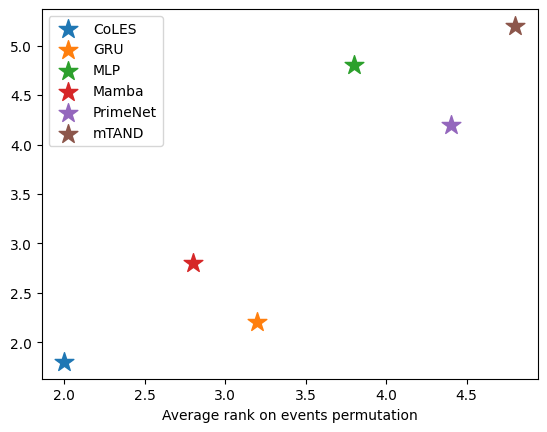

In [56]:
_, ax = plt.subplots()

for m in main_ranks.index:
    ax.scatter([main_ranks.at[m]], [perm_kl_ranks.at[m]], marker="*", s=200, label=m)

ax.legend()
ax.set_xlabel("Average rank on evaluation")
ax.set_xlabel("Average rank on events permutation")

plt.show()

# Critical differences

In [27]:
df = df_eval.query("dataset == 'physionet2012'")[["method", "seed", "metric"]]
df.columns = ["classifier_name", "dataset_name", "accuracy"]
df

,classifier_name,dataset_name,accuracy
0,mtand,0,0.844177
1,mtand,1,0.842219
2,mtand,2,0.843357
3,mtand,3,0.841333
4,mtand,4,0.845710
...,...,...,...
15,primenet,15,0.836894
16,primenet,16,0.837698
17,primenet,17,0.834237
18,primenet,18,0.843152


In [28]:
draw_cd_diagram(df, fname="notebooks/figures/cd-physionet.png")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

['mtand' 'gru' 'mlp' 'mamba' 'coles' 'primenet']
coles        2.0
gru         16.0
mamba        0.0
mlp          0.0
mtand        1.0
primenet     1.0
dtype: float64
mamba       4.95
mlp         4.95
primenet    3.35
coles       3.30
mtand       3.20
gru         1.25
dtype: float64
('gru', 'mamba', 1.9073486328125e-06, True)
('gru', 'mlp', 1.9073486328125e-06, True)
('gru', 'mtand', 5.7220458984375e-06, True)
('coles', 'gru', 1.9073486328125e-05, True)
('gru', 'primenet', 4.76837158203125e-05, True)
('mamba', 'mtand', 0.0003223419189453125, True)
('mamba', 'primenet', 0.0031528472900390625, True)
('mlp', 'mtand', 0.0042209625244140625, True)
('mlp', 'primenet', 0.012079238891601562, False)
('coles', 'mamba', 0.026641845703125, False)
('coles', 'mlp', 0.082550048828125, False)
('coles', 'primenet', 0.6742229461669922, False)
('coles', 'mtand', 0.7285060882568359, False)
('mamba', 'mlp', 0.7841262817382812, False)
('mtand', 'primenet', 0.7841262817382812, False)
Index(['mamba', 'mlp', 'p

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because